In [ ]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

interactive_figures = True
if interactive_figures:
    %matplotlib widget
    figsize = (9,3)
else:
    figsize = (13,4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Gaussian Processes

## Filling Values Using a Model

**If we want to fill missing values better, we need to _predict_ them**

We need a _model_, which can infer their value

* All the approaches seen so far can be considered (extremely simple) models
* ...We just need a more advanced one!

**What are the _desired properties_ of the model we seek?**

Given a gap (i.e. one or more contiguous missing values), the model:

* Must be able to make a prediction about the missing values
* ...Which is consistent with all the available observations
* I.e. it should be able to _interpolate_ the data (in generalized sense)

**Most ML models _cannot_ be used for filling (in a straightforward fashion)**

## Filling Values Using a Model

**Density estimation does not (natively) provide predictions**

To be fair, predictions can be _extracted_ from a density estimator:

- Given an estimator $f({\bf x}, \theta)$ for $P({\bf x})$ we can find the most likely value for $\bf x$ by solving:
$$
\text{argmax}_{\bf x} f({\bf x}, \theta)
$$
- This is a _Maximum A Posteriori (MAP)_
- ...And its what most regressors/classifiers natively compute

However, with a density estimator, computing the MAP can be _very expensive_

**Auto-regressors makes use of past observations, but not the future ones**

* They are designed for _extrapolation_ (predict beyond the boundaries)
* ...And not for _interpolation_

## Gaussian Processes

**One of the few viable ML models is given by _Gaussian Processes (GP)_:**

* A GP is a _stochastic process_, i.e. a collection of indexed random variables
* Each variable $y_{x}$ is indexed via a tuple $x$ (e.g. time, space, temperature...)
* The index is _continuous_ and the collection _infinite_
* Every finite subset of $y_{x}$ variables follows a _Multivariate Normal Distribution_

**Intuitively: it's a bunch of correlated, named, Normally-distributed variables**

For example:

* $y_{x}$ could be the occupancy/twitter volume at time $x$
* $y_{x}$ could be the rainfall rate at location $x$

**In general $y_{x}$ is the value of a (stochastic) function for input $x$**

## Multivariate Normal Distritbuion

**The multivariate normal distribution:**

* Has a closed-form density function that is (relatively) easy to compute
* Is uniquely defined by its (vector) mean $\bf \mu$
* ...And its _covariance matrix $\Sigma$_

If we assume centered data (${\bf \mu} = {\bf 0}$), then _knowing $\Sigma$ is enough_

**Say we have a vector of observations $\bf \hat{y}_X$, for a set of indexes/input values $X$**

Then, if we manage to _know $\Sigma$_, we can compute:

* The probability _density_ $f({\bf \hat{y}_X})$
* The _conditional density_ $f(\hat{y}_x \mid {\bf \hat{y}_{X \setminus x}})$ of one observation w.r.t. the others

There are [closed-form expressions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for doing that

## Defining the Covariance Matrix

**We define $\Sigma$ by assuming that the _covariance depends on the indexes_**

Intuitively, it depends on the _input values_

* Given two variables $y_{x_i}$ and $y_{x_j}$, their covariance is given by $K(x_i, x_j)$
* Where $K$ is called a _kernel function_ (and is user chosen)

**Given any finite set of variables $\{y_{x_1}, \ldots y_{x_n}\}$, the covariance matrix is:**

$$\Sigma = \left(\begin{array}{cccc}
K(x_1, x_1) & K(x_1, x_2) & \cdots & K(x_1, x_n) \\
K(x_2, x_1) & K(x_2, x_2) & \cdots & K(x_2, x_n) \\
\vdots & \vdots & \vdots & \vdots \\
K(x_n, x_1) & K(x_n, x_2) & \cdots & K(x_n, x_n) \\
\end{array}\right)$$

* I.e. it's entirely specified via the kernel
* But choosing the kernel completely by hand would still be _too difficult_

## Fitting a Gaussian Process

**In practice, to define the kernel we:**

* Pick a _parameterized_ kernel function $K_{\theta}(x_i, x_j)$, where $\theta$ = parameter vector
* Collect training observations $\bf \hat{y}_X$

**Then we choose $\theta$ so as to maximize the _likelihood_ of the training data, i.e.:**

$$
\text{argmax}_\theta f({\bf \hat{y}_X}, \theta)
$$

* Where $f({\bf \hat{y}_X}, \theta)$ is the _estimated_ probability density of the observations

**The training problem**

* Is a (possibly challenging) numerical optimization problem
* ...Which is typically solved to _local optimality_ (e.g. via gradient descent)

## Gaussian Processes in scikit-learn

**Let's see how to use Gaussian Processes in scikit-learn**

First, let us choose a target function:

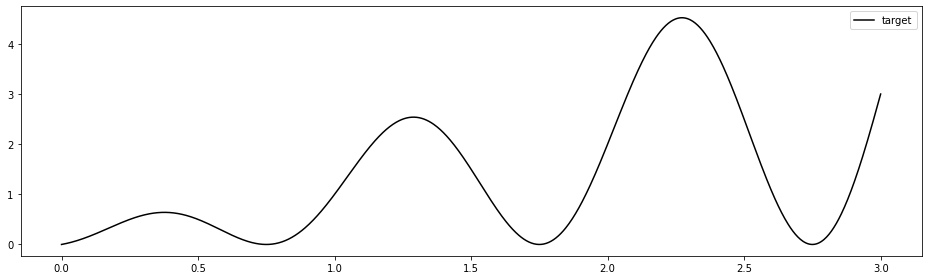

In [3]:
f = lambda x: x * np.sin(2*np.pi*x) + x # target function
x = np.linspace(0, 3, 1000)
y = pd.Series(index=x, data=f(x))
nab.plot_gp(target=y, figsize=figsize)

## Gaussian Processes in scikit-learn

**Let's see how to use Gaussian Processes in scikit-learn**

Then we build a small training set:

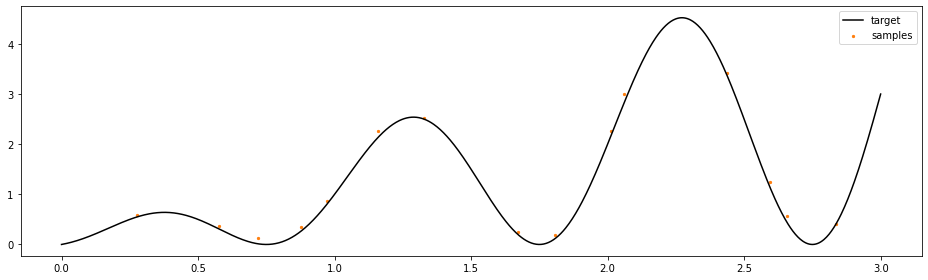

In [4]:
np.random.seed(42)
n_tr = 15
x_tr = np.linspace(0.2, 2.8, n_tr) + 0.2*np.random.rand(n_tr)
x_tr.sort()
y_tr = pd.Series(index=x_tr, data=f(x_tr) + 0.2*np.random.rand(n_tr))
nab.plot_gp(target=y, samples=y_tr, figsize=figsize)

## Gaussian Processes in scikit-learn

**Let's see how to use Gaussian Processes in scikit-learn**

Then we need to choose a kernel

* There are [many available options](https://scikit-learn.org/stable/modules/gaussian_process.html)
* We will _start_ with a simple Radial Basis Function (i.e. Gaussian) kernel

$$
K(x_i, x_j) = e^{-\frac{d(x_i, x_j)^2}{2l}}
$$

The correlation _decreases exponentially with the (Euclidean) distance_ $d(x_i, x_j)$:

* Intuitively, _the closer the points, the higher the correlation_
* The $l$ parameter (_scale_) control the rate of the reduction

## Gaussian Processes in scikit-learn

**Here's how to use an RBF kernel in scikit-learn**

In [5]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(1, (1e-3, 1e3))

**The RBF kernel has a single parameter, representing its _scale_**

The extra (tuple) parameter represents a pair of _bounds_

* During training only parameter values within the boundaries will be considered
* Bounds can be very useful for controlling the training process
* ...Based on the available domain information

## Gaussian Processes in scikit-learn

**Now we can train a Gaussian Process**

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input
gp.kernel_

RBF(length_scale=0.229)

* _Restarts_ are needed to mitigate issues due to local optima

**And then we can obtain the predictions:**

In [7]:
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
xp = pd.Series(index=y.index, data=xp)
std = pd.Series(index=y.index, data=std)

* The model returns predictions (i.e. the estimated _mean_ of the distribution)
* ...But can also return their _standard deviation_!

## Gaussian Processes in scikit-learn

**We can now plot the predictions**

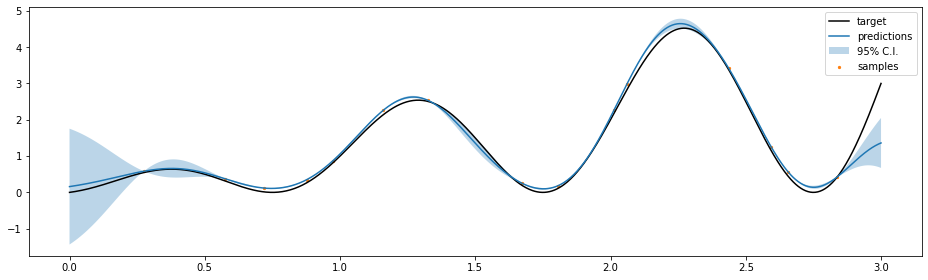

In [8]:
nab.plot_gp(target=y, samples=y_tr, pred=xp, std=std, figsize=figsize)

* The prediction (point estimates) correspond to the blue line
* The confidence interval to the light blue areas

**But how did we manage that?**

## Behind the Scenes

There are _two tricks at work_ here:

**1) The training examples $\bf \hat{y}_X$ are _part of the GP parameters_**

* This is similar to what we have (e.g.) in KDE
* ...And quite different from other ML methods (e.g. NN, DTs, SVMs...)

Given an new input value $x$, the GP output corresponds to:
$$
f\left(y_x \mid {\bf \hat{y}_X}\right)
$$
* I.e. the probability of $y_x$ _conditioned on the known examples_

**2) For computing $\Sigma$, we only need to know the _input values_ (i.e. $X$ and $x$)**

* This is by construction: all our kernels $K(x_i, x_j)$ are built this way
* Which means that we can compute $f\left(y_x \mid {\bf \hat{y}_X}\right)$ via a closed-form expression


## Behind the Scenes

**Thanks to this, for $f\left(y_x \mid {\bf \hat{y}_X}\right)$ we can get**

The _conditional mean_ (which is also the MAP):
$$
\arg\max_{y_x} f\left(y_x \mid {\bf \hat{y}_X}\right)
$$
* This will be our "prediction"

The _conditional standard deviation_
$$
\sqrt{{\rm Var} \left[ f\left(y_x \mid {\bf \hat{y}_X}\right)\right]}
$$
* This is used to define the confidence intervals

**In practice, we GP output is _a probability distribution_**

## A Numeric Example

**As an example, say we want a prediction for $x = 2.5$, i.e. $y_{2.5}$**

...And let's assume that our training set contains _only one example_

* We will consider _separately_ the tenth and first example in our dataset
* We have: $(\hat{x}_9, \hat{y}_{\hat{x}_9}) \simeq (2.01, 2.27)$
 and $(\hat{x}_0, \hat{y}_{\hat{x}_0}) \simeq (0.27, 0.58)$
 
**The covariance matrix in the two cases is therefore:**

$$
\Sigma_{y_x, \hat{y}_{\hat{x}_9}} = \left(\begin{array}{cc}
K(2.01, 2.01) & K(2.01, 2.5) \\
K(2.5, 2.01) & K(2.5, 2.5) \\
\end{array}\right)
$$
$$
\Sigma_{y_x, \hat{y}_{\hat{x}_0}} = \left(\begin{array}{cc}
K(0.27, 0.27) & K(0.27, 2.5) \\
K(2.5, 0.27) & K(2.5, 2.5) \\
\end{array}\right)
$$

* Each matrix defines a multivariate Normal distribution

## Behind the Scenes

**Let's actually build the matrices in Python**

* Note: scikit-learn kernels are not designed to be used on individual points
* So, for this we will rely on basic numpy methods

**We start with $\hat{x}_9$ and $x$, which are _close to each other_**

In [9]:
from scipy.stats import multivariate_normal
X9, X0, X = [[x_tr[9]]], [[x_tr[0]]], [[2.5]] # Must be 2D
sigma_9x = np.array([[kernel(X9, X9)[0,0], kernel(X9, X)[0,0]],
                    [kernel(X, X9)[0,0], kernel(X, X)[0,0]]])
f_9x = multivariate_normal([0, 0], cov=sigma_9x)

**Then we do the same for $\hat{x}_0$ and $x$, which are _far apart_**

In [10]:
sigma_0x = np.array([[kernel(X0, X0)[0,0], kernel(X0, X)[0,0]],
                    [kernel(X, X0)[0,0], kernel(X, X)[0,0]]])
f_0x = multivariate_normal([0, 0], cov=sigma_0x)

## Behind the Scenes

**$\hat{x}_9$ and $x$ are _close to each other_, so $\hat{y}_{\hat{x}_9}$ and $y_x$ are _strongly correlated_**

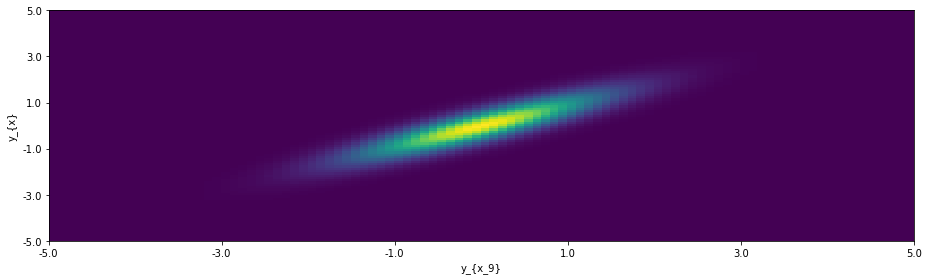

In [12]:
yr = np.linspace(-5, 5, 100)
nab.plot_distribution_2D(f_9x, yr, yr, figsize=figsize)
plt.xlabel('y_{x_9}'); plt.ylabel('y_{x}'); plt.tight_layout()

* Still, if we know _neither_ $\hat{y}_{\hat{x}_9}$ nor $y_x$, we can only say that they are likely _both zero_

## Behind the Scenes

**But we _do know_ $\hat{y}_{\hat{y}_9}$! So, we can use this information_**

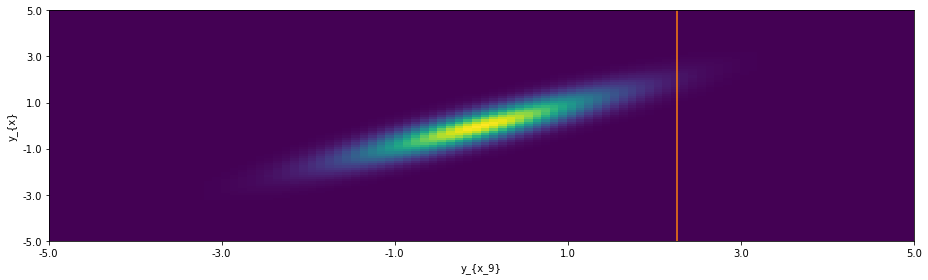

In [13]:
nab.plot_distribution_2D(f_9x, yr, yr, figsize=figsize)
plt.axvline(10*(y_tr[x_tr[9]] + 5), color='tab:orange');
plt.xlabel('y_{x_9}'); plt.ylabel('y_{x}'); plt.tight_layout()

* Given the observation, the most likely value for $y_{x}$ _changes considerably_

## Behind the Scenes

**$\hat{x}_0$ and $x$ are _far apart_, so $\hat{y}_{\hat{x}_0}$ and $y_x$ are _loosely correlated_**

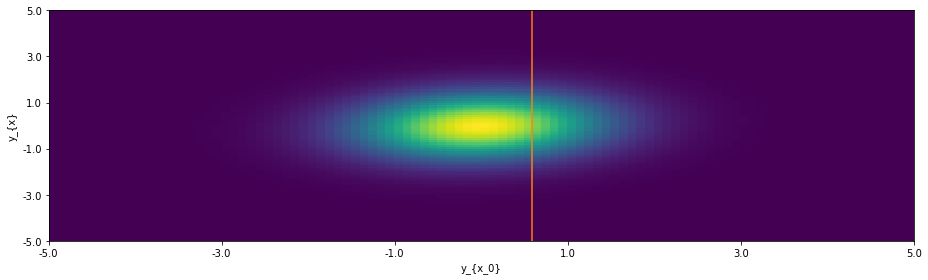

In [14]:
nab.plot_distribution_2D(f_0x, yr, yr, figsize=figsize)
plt.axvline(10*(y_tr[x_tr[0]] + 5), color='tab:orange');
plt.xlabel('y_{x_0}'); plt.ylabel('y_{x}'); plt.tight_layout()

* Knowing $\hat{y}_{\hat{x}_0}$ is not going to be of much help here

## Behind the Scenes

**So, a few key insight to keep in mind:**

* Superficially, GPs behave like _functions that output probability distribution_
* Internally, this is enabled by _two components_:
   - _The kernel_, defining how all the points are correlated
   - _A set of observations_, use to obtain conditional distributions

**In scikit-learn:**

When we call the `fit` method:

* The optimizer adjusts the kernel parameters
* ...And _the observations $\hat{y}_{\hat{x}}$ are stored_

When we call the `predict` method:

* The covariance matrix is built
* The model computes the conditional distributions

## How to Improve the Model

**Now, let's try to improve our model**

We need to _choose a kernel_ appropriate to our dataset

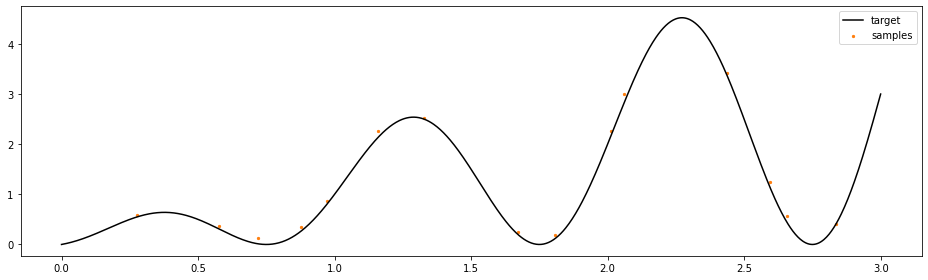

In [15]:
nab.plot_gp(target=y, samples=y_tr, figsize=figsize)

* We a bit of _noise_, a _period_, and a _trend_

## How to Improve the Model

**So, let us deal with the noise first**

In [16]:
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = WhiteKernel(0.1, (1e-3, 1e3))
kernel += RBF(1, (1e-2, 1e2))

`WhiteKernel` captures the presence of _noise_ in the data

$$
K(x_i, x_j) = \sigma^2 \text{ iff } x_i = x_j, 0 \text{ otherwise}
$$


* The only parameter of `WhiteKernel` represents the noise level $\sigma^2$
* A small noise level prevent overfitting the data
* ...But too much noise leads to useless predictions!

## How to Improve the Model

**It's often a good idea to have magnitude parameters in the kernel**

In [17]:
from sklearn.gaussian_process.kernels import ConstantKernel

kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))

`ConstantKernel` is a constant factor (in this case a relative weight)

* ...And allows the optimizer to tune the magnitude of the RBF kernel

**Let's repeat training again:**

In [18]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input
print(gp.kernel_)

WhiteKernel(noise_level=0.01) + 2.21**2 * RBF(length_scale=0.321)


/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


## How to Improve the Model

**Let us see the new predictions**

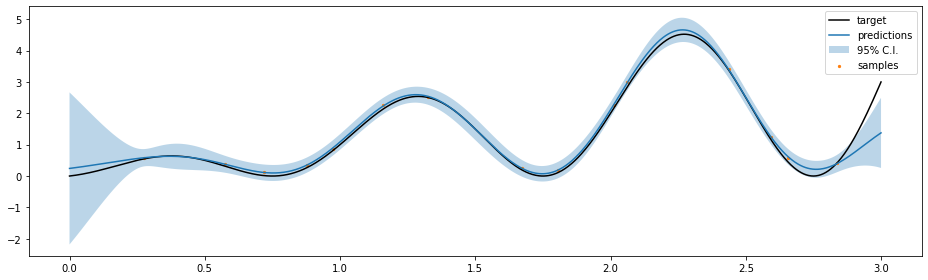

In [20]:
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
xp = pd.Series(index=y.index, data=xp)
std = pd.Series(index=y.index, data=std)
nab.plot_gp(target=y, samples=y_tr, pred=xp, std=std, figsize=figsize)

* Better, but we are still not exploiting the period and the trend

## How to Improve the Model

**So, let us take them into account, starting with the period**

In [21]:
from sklearn.gaussian_process.kernels import ExpSineSquared
kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))
kernel += ExpSineSquared(1, 1, (1e-2, 1e2), (1e-2, 1e2))

`ExpSineSquared` captures the period:

$$
K(x_i, x_j) = e^{-2 \frac{\sin^2 \left(\pi \frac{d(x_i,x_j)}{p}\right)}{l^2}}
$$

* The correlation grows is the distance is close to a multiple of the period $p$
* The scale parameter $l$ control the rate of decrease/increase
* In the implementation, the first parameter is $l$ and the second $p$

## How to Improve the Model

**Now, let's try to capture the trend**

In [22]:
from sklearn.gaussian_process.kernels import DotProduct
kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))
kernel += ExpSineSquared(1, 1, (1e-2, 1e2), (1e-2, 1e2))
kernel += DotProduct(1, (1e-2, 1e2))

`DotProduct` (somewhat) captures the trend:

$$
K(x_i, x_j) = \sigma^2 + x_i x_j
$$

* The larger the $x$ values, the larger the correlation
* This allows the distance from the mean (which is zero) to grow
* The $\sigma$ parameter controls the base level of correlation
* Unlike all kernels so far `DotProduct` is _not translation-invariant_ (we sa!

## How to Improve the Model

**The new predictions are a bit better at the edges of the plot**

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


WhiteKernel(noise_level=0.01) + 1.17**2 * RBF(length_scale=0.305) + ExpSineSquared(length_scale=2.17, periodicity=0.939) + DotProduct(sigma_0=0.0197)


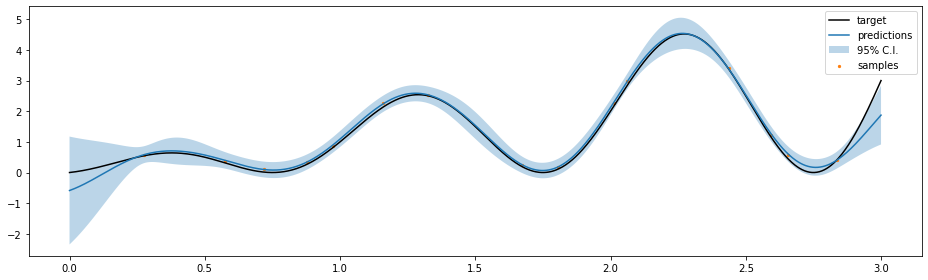

In [23]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input
print(gp.kernel_)
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
xp = pd.Series(index=y.index, data=xp)
std = pd.Series(index=y.index, data=std)
nab.plot_gp(target=y, samples=y_tr, pred=xp, std=std, figsize=figsize)

## Considerations

**Gaussian Processes are a _very flexible_ ML technique**

* They can be used to making predictions
* ...Together with their confidence intervals
* ...But also for (conditional) density estimation
* ...And for generating data

**They are _non-trivial to use_:**

* In particular, choosing a kernel requires some practice and some understanding
* Automating the process is possible, but complex (grid search is likely not enough)

**Gaussian processes tend to perform better:**

* When _interpolating_ (i.e. predicting values between points in the training set)
* ...Rather than when _extrapolating_ (i.e. making predictions far from the training set)
* And also when there are only a _few input dimensions_
